In [1]:
import pandas as pd
import geopandas as gpd
import os

In [2]:
gdf_osm_parking = gpd.read_file("osm_parking.geojson")

gdf_osm_parking.head()

,osm_id,name,access,amenity,building,building:levels,capacity,fee,parking,geometry
0,25509346,Starvine Parking Deck,None,parking,parking,None,None,None,multi-storey,"POLYGON ((-84.30911 33.79582, -84.309 33.79561..."
1,26800176,None,yes,parking,yes,None,None,yes,multi-storey,"POLYGON ((-84.38865 33.77504, -84.38816 33.775..."
2,28507336,Library Parking,yes,parking,None,None,None,no,multi-storey,"POLYGON ((-84.29414 33.77372, -84.29414 33.773..."
3,28507523,East Lake Park & Ride,customers,parking,None,None,611,no,surface,"POLYGON ((-84.3131 33.7641, -84.3131 33.76401,..."
4,28507673,East Lake Park & Ride,yes,parking,None,None,None,no,surface,"POLYGON ((-84.31345 33.76553, -84.31443 33.765..."


In [3]:
gdf_osm_parking.groupby("parking")["osm_id"].nunique()

parking
carports          15
garage             4
lane              35
multi-storey     486
street_side       53
surface         1517
underground        5
valet              1
yes                1
Name: osm_id, dtype: int64

In [7]:
# Capacity per geometry area

## project to 

gdf_osm_parking_projected = gdf_osm_parking.to_crs("EPSG:26766")

gdf_osm_parking_projected.head()

,osm_id,name,access,amenity,building,building:levels,capacity,fee,parking,geometry
0,25509346,Starvine Parking Deck,None,parking,parking,None,None,None,multi-storey,"POLYGON ((-150952.9 1387454.275, -150922.886 1..."
1,26800176,None,yes,parking,yes,None,None,yes,multi-storey,"POLYGON ((-175288.587 1380403.447, -175137.312..."
2,28507336,Library Parking,yes,parking,None,None,None,no,multi-storey,"POLYGON ((-146572.626 1379317.914, -146572.926..."
3,28507523,East Lake Park & Ride,customers,parking,None,None,611,no,surface,"POLYGON ((-152408.443 1375935.334, -152408.412..."
4,28507673,East Lake Park & Ride,yes,parking,None,None,None,no,surface,"POLYGON ((-152502.001 1376455.792, -152802.339..."


In [8]:
gdf_osm_parking_projected.crs

<Projected CRS: EPSG:26766>
Name: NAD27 / Georgia East
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Georgia - counties of Appling; Atkinson; Bacon; Baldwin; Brantley; Bryan; Bulloch; Burke; Camden; Candler; Charlton; Chatham; Clinch; Coffee; Columbia; Dodge; Echols; Effingham; Elbert; Emanuel; Evans; Franklin; Glascock; Glynn; Greene; Hancock; Hart; Jeff Davis; Jefferson; Jenkins; Johnson; Lanier; Laurens; Liberty; Lincoln; Long; Madison; McDuffie; McIntosh; Montgomery; Oglethorpe; Pierce; Richmond; Screven; Stephens; Taliaferro; Tattnall; Telfair; Toombs; Treutlen; Ware; Warren; Washington; Wayne; Wheeler; Wilkes; Wilkinson.
- bounds: (-83.47, 30.36, -80.77, 34.68)
Coordinate Operation:
- name: Georgia CS27 East zone
- method: Transverse Mercator
Datum: North American Datum 1927
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

In [10]:
gdf_osm_parking_projected[gdf_osm_parking_projected["capacity"].notnull()].groupby("parking")["osm_id"].nunique()

parking
lane             10
multi-storey     14
street_side       1
surface         171
Name: osm_id, dtype: int64

In [17]:
gdf_osm_parking_projected["osm_geom_area"] = gdf_osm_parking_projected.geometry.area * 0.092903 # convert ot m2

gdf_osm_parking_projected["capacity"] = gdf_osm_parking_projected["capacity"].apply(lambda x: x.replace("+", "") if type(x) == str else x).astype(float) # convert type

gdf_osm_parking_projected["area_per_capacity"] = gdf_osm_parking_projected["osm_geom_area"] / gdf_osm_parking_projected["capacity"]

In [19]:
gdf_osm_parking_projected.groupby("parking")["area_per_capacity"].mean()

parking
carports              NaN
garage                NaN
lane            16.309453
multi-storey     7.223329
street_side     20.001809
surface         33.444207
underground           NaN
valet                 NaN
yes                   NaN
Name: area_per_capacity, dtype: float64

<Axes: title={'center': 'area_per_capacity'}, xlabel='parking'>

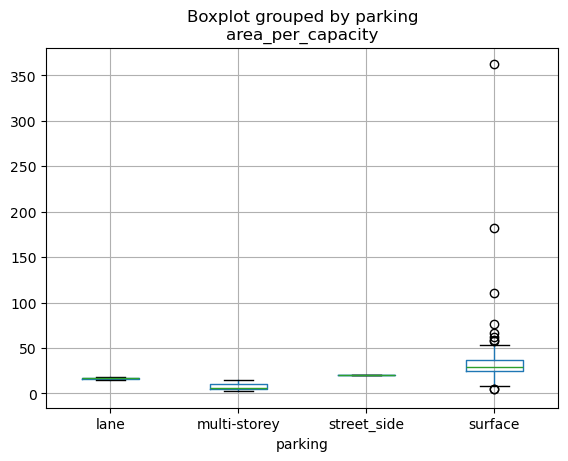

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# lane_parking = gdf_osm_parking_projected[gdf_osm_parking_projected["parking"] == "lane"]["area_per_capacity"]
# mstorey_parking = gdf_osm_parking_projected[gdf_osm_parking_projected["parking"] == "multi-storey"]["area_per_capacity"]
# surface_parking = gdf_osm_parking_projected[gdf_osm_parking_projected["parking"] == "surface"]["area_per_capacity"]

# data_box_plot = [lane_parking, mstorey_parking, surface_parking]

# fig = plt.figure(figsize =(10, 7))

# ax = fig.add_subplot()

# bp = ax.boxplot(data_box_plot)

# # show plot
# plt.show()

gdf_osm_parking_projected[gdf_osm_parking_projected["capacity"].notnull()].boxplot(column="area_per_capacity",
                                 by="parking")

Text(0, 0.5, 'Geometry Area (sqm)')

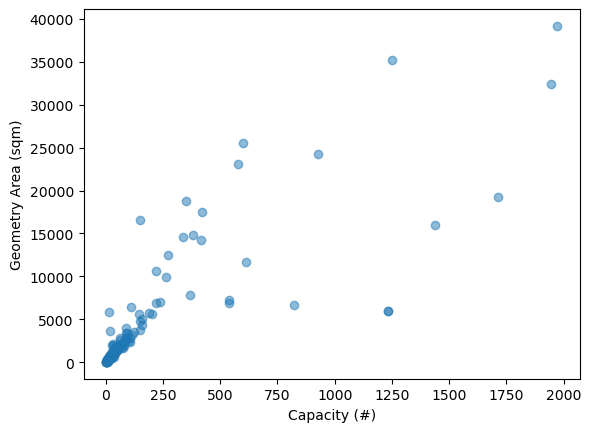

In [32]:
plt.scatter(x=gdf_osm_parking_projected[gdf_osm_parking_projected["parking"] == "surface"]["capacity"],
           y=gdf_osm_parking_projected[gdf_osm_parking_projected["parking"] == "surface"]["osm_geom_area"],
           alpha=0.5)
plt.xlabel("Capacity (#)")
plt.ylabel("Geometry Area (sqm)")

Text(0, 0.5, 'Geometry Area (sqm)')

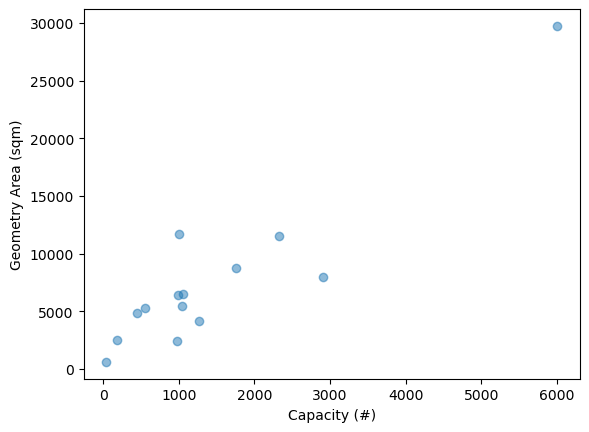

In [33]:
plt.scatter(x=gdf_osm_parking_projected[gdf_osm_parking_projected["parking"] == "multi-storey"]["capacity"],
           y=gdf_osm_parking_projected[gdf_osm_parking_projected["parking"] == "multi-storey"]["osm_geom_area"],
           alpha=0.5)

plt.xlabel("Capacity (#)")
plt.ylabel("Geometry Area (sqm)")

In [34]:
# apply linear regression

from sklearn.linear_model import LinearRegression

In [39]:
data_building = gdf_osm_parking_projected[gdf_osm_parking_projected["parking"] == "multi-storey"]
data_building = data_building[data_building["capacity"].notnull()]

data_surface = gdf_osm_parking_projected[gdf_osm_parking_projected["parking"] == "surface"]
data_surface = data_surface[data_surface["capacity"].notnull()]

x_building = data_building[["osm_geom_area"]]
y_building = data_building[["capacity"]]

x_surface = data_surface[["osm_geom_area"]]
y_surface = data_surface[["capacity"]]


reg_building = LinearRegression().fit(x_building, y_building)

reg_surface = LinearRegression().fit(x_surface, y_surface)

In [47]:
reg_building.coef_

array([[0.19640404]])

In [48]:
reg_surface.coef_

array([[0.04249784]])

# Merge with SafeGraph POI

In [49]:
df_safegraph_parking = pd.read_csv("../data/parking_lot/ATL_SafeGraph_filtered.csv")

In [50]:
df_safegraph_parking.shape

(19350, 6)

In [51]:
df_safegraph_parking.head()

,PLACEKEY,POLYGON_WKT,WKT_AREA_SQ_METERS,RELATED_POI,LONGITUDE,LATITUDE
0,zzz-222@8g6-x82-h89,"list(c(-84.1850990366146, -84.1851906498244, -...",102,NaN,-84.185144,33.824820
1,zzz-222@8g6-x8j-n89,"list(c(-84.2213041494029, -84.2212968257044, -...",6285,NaN,-84.222369,33.743690
2,zzz-222@8g6-xpk-nwk,"list(c(-84.2697920844036, -84.2699818743651, -...",839,NaN,-84.270137,33.615502
3,zzz-222@8g6-y3w-skf,"list(c(-84.2711732932715, -84.2710495938455, -...",9479,NaN,-84.270623,34.087208
4,zzz-222@8g6-y44-fj9,"list(c(-84.2654832952327, -84.2654998621948, -...",430,NaN,-84.265731,34.067523


In [52]:
df_safegraph_parking.dtypes

PLACEKEY               object
POLYGON_WKT            object
WKT_AREA_SQ_METERS      int64
RELATED_POI           float64
LONGITUDE             float64
LATITUDE              float64
dtype: object

In [53]:
df_safegraph_parking["POLYGON_WKT"] = df_safegraph_parking["POLYGON_WKT"].apply(lambda x: x.replace("list(c", ""))
df_safegraph_parking["POLYGON_WKT"] = df_safegraph_parking["POLYGON_WKT"].apply(lambda x: x.replace("))", ")"))
df_safegraph_parking["POLYGON_WKT"] = df_safegraph_parking["POLYGON_WKT"].apply(lambda x: x.replace("(", ""))
df_safegraph_parking["POLYGON_WKT"] = df_safegraph_parking["POLYGON_WKT"].apply(lambda x: x.replace(")", ""))
df_safegraph_parking["POLYGON_WKT"] = df_safegraph_parking["POLYGON_WKT"].apply(lambda x: x.replace("\n", ""))
df_safegraph_parking["POLYGON_WKT"] = df_safegraph_parking["POLYGON_WKT"].apply(lambda x: x.replace("c", ""))
df_safegraph_parking.head()

,PLACEKEY,POLYGON_WKT,WKT_AREA_SQ_METERS,RELATED_POI,LONGITUDE,LATITUDE
0,zzz-222@8g6-x82-h89,"-84.1850990366146, -84.1851906498244, -84.1851...",102,NaN,-84.185144,33.824820
1,zzz-222@8g6-x8j-n89,"-84.2213041494029, -84.2212968257044, -84.2211...",6285,NaN,-84.222369,33.743690
2,zzz-222@8g6-xpk-nwk,"-84.2697920844036, -84.2699818743651, -84.2700...",839,NaN,-84.270137,33.615502
3,zzz-222@8g6-y3w-skf,"-84.2711732932715, -84.2710495938455, -84.2710...",9479,NaN,-84.270623,34.087208
4,zzz-222@8g6-y44-fj9,"-84.2654832952327, -84.2654998621948, -84.2656...",430,NaN,-84.265731,34.067523


In [54]:
def convert_to_polygon(coord_str):
    # Remove parentheses and split into individual coordinates
    coords = coord_str.split(", ")
    # Convert to floats
    coords = [float(coord) for coord in coords]
    
    # Separate the list into longitude and latitude
    lon = coords[:len(coords)//2]
    lat = coords[len(coords)//2:]
    
    # Pair lat and lon into (x, y) tuples
    polygon_coords = list(zip(lon, lat))
    
    # Create and return a Polygon
    return Polygon(polygon_coords)

In [55]:
from shapely.geometry import Polygon

In [56]:
df_safegraph_parking['geometry'] = df_safegraph_parking['POLYGON_WKT'].apply(convert_to_polygon)

In [57]:
gdf_safegraph_parking = gpd.GeoDataFrame(df_safegraph_parking, geometry='geometry', crs="EPSG:4326")

In [58]:
gdf_safegraph_parking.shape

(19350, 7)

In [59]:
gdf_safegraph_parking.to_file("safegraph_parking_1.geojson", driver="GeoJSON")

In [38]:
from glob import glob

In [41]:
all_parking_safegraph_fl = glob("../data/parking_lot/raw/*.csv")

In [42]:
len(all_parking_safegraph_fl)

64

In [43]:
df_sg = pd.DataFrame()

for f in all_parking_safegraph_fl:

    df_sg = pd.concat([pd.read_csv(f), df_sg])

In [44]:
df_sg.shape

(5984517, 6)

In [45]:
df_sg.columns

Index(['PLACEKEY', 'LATITUDE', 'LONGITUDE', 'POLYGON_WKT',
       'WKT_AREA_SQ_METERS', 'RELATED_POI'],
      dtype='object')

In [46]:
df_sg.head(3)

,PLACEKEY,LATITUDE,LONGITUDE,POLYGON_WKT,WKT_AREA_SQ_METERS,RELATED_POI
0,zzz-222@63j-92s-xdv,39.328655,-84.277451,POLYGON ((-84.27716632403255 39.32901243407676...,3373,"[""222-222@63j-92s-hdv"",""228-222@63j-92s-xdv""]"
1,zzz-222@63j-92z-zvf,39.381537,-84.385519,POLYGON ((-84.38449157622921 39.38249301809495...,14182,"[""222-222@63j-92z-zvf"",""222-223@63j-92z-zvf"",""..."
2,zzz-222@63j-937-hbk,39.389120,-84.370805,POLYGON ((-84.37072293554394 39.38917386725801...,179,[]


In [49]:
from shapely import wkt

df_sg['geometry'] = df_sg['POLYGON_WKT'].apply(wkt.loads)

In [50]:
gdf_sg = gpd.GeoDataFrame(df_sg, geometry="geometry", crs=4326)

In [51]:
gdf_sg_filtered = gdf_sg[gdf_sg["PLACEKEY"].isin(df_safegraph_parking.PLACEKEY.unique().tolist())]

In [52]:
gdf_sg_filtered.shape

(19350, 7)

In [53]:
gdf_sg_filtered.head(3)

,PLACEKEY,LATITUDE,LONGITUDE,POLYGON_WKT,WKT_AREA_SQ_METERS,RELATED_POI,geometry
2776,zzz-222@8g6-x3v-ks5,33.724823,-84.107706,POLYGON ((-84.10689892347354 33.72651614379912...,28687,"[""zzy-222@8g6-x3v-ks5""]","POLYGON ((-84.10690 33.72652, -84.10689 33.726..."
2777,zzz-222@8g6-x3z-qs5,33.693855,-84.075111,POLYGON ((-84.07575503370121 33.69415695003182...,4352,"[""224-222@8g6-x4t-gc5"",""22b-222@8g6-x4t-gc5""]","POLYGON ((-84.07576 33.69416, -84.07575 33.694..."
2780,zzz-222@8g6-x75-pjv,33.846035,-84.257664,POLYGON ((-84.25758064959409 33.84631212654212...,1236,"[""222-222@8g6-yn3-k9f"",""zzw-222@8g6-x75-pjv"",""...","POLYGON ((-84.25758 33.84631, -84.25758 33.846..."


In [54]:
gdf_sg_filtered[["PLACEKEY", "LATITUDE", "LONGITUDE", "WKT_AREA_SQ_METERS", "geometry"]]\
.to_file("safegraph_parking.geojson", driver="GeoJSON")

# Load SafeGraph Parking

In [60]:
gdf_safe_graph = gpd.read_file("safegraph_parking.geojson")

gdf_safe_graph.head()

,PLACEKEY,LATITUDE,LONGITUDE,WKT_AREA_SQ_METERS,geometry
0,zzz-222@8g6-x3v-ks5,33.724823,-84.107706,28687,"POLYGON ((-84.1069 33.72652, -84.10689 33.7264..."
1,zzz-222@8g6-x3z-qs5,33.693855,-84.075111,4352,"POLYGON ((-84.07576 33.69416, -84.07575 33.694..."
2,zzz-222@8g6-x75-pjv,33.846035,-84.257664,1236,"POLYGON ((-84.25758 33.84631, -84.25758 33.846..."
3,zzz-222@8g6-x7c-j7q,33.824909,-84.261364,3466,"POLYGON ((-84.26095 33.82522, -84.26093 33.825..."
4,zzz-222@8g6-x8m-pd9,33.704086,-84.253256,549,"POLYGON ((-84.25314 33.70421, -84.25306 33.704..."


In [ ]:
# Safe Graph intersected with OSM

gdf_int = gdf_safe_graph